In [1]:
using PyPlot
using Printf

PyPlot.svg(true)

true

In [2]:
function jacobi_update(dx, f_array, phi)
    phi_new = copy(phi)
    
    for i in 2:size(phi_new,1)-1
        phi_new[i] = 0.5*(phi[i-1] + phi[i+1]) - 0.5*dx*dx*f_array[i]
    end
    
    phi_new
end

jacobi_update (generic function with 1 method)

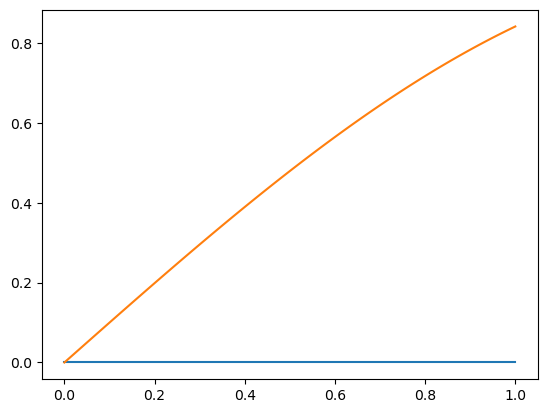

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x11a5f06a0>

In [3]:
xs = collect(0:0.01:1)
f_array = sin.(xs)
phi0 = zeros(size(xs,1))
phi_exact = -sin.(xs) .+ xs*sin(1)
plot(xs, phi0)
plot(xs, f_array)

In [4]:
phi = copy(phi0)
for i in 1:10000
    phi = jacobi_update(xs[2]-xs[1], f_array, phi)
end

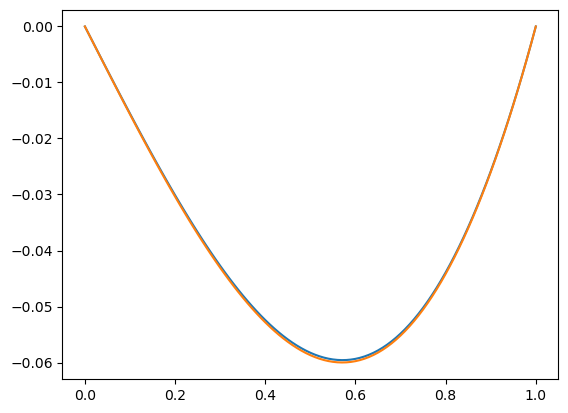

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1304f7e80>

In [5]:
plot(xs, phi)
plot(xs, phi_exact)

In [6]:
function gs_update(dx, f_array, phi)
    phi_new = copy(phi)
    
    for i in 2:size(phi_new,1)-1
        phi_new[i] = 0.5*(phi_new[i-1] + phi_new[i+1]) - 0.5*dx*dx*f_array[i]
    end
    
    phi_new
end

gs_update (generic function with 1 method)

In [7]:
phi = copy(phi0)
for i in 1:10000
    phi = gs_update(xs[2]-xs[1], f_array, phi)
end

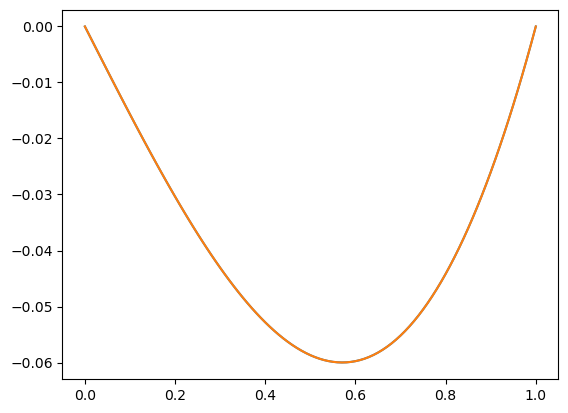

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1308999e8>

In [8]:
plot(xs, phi)
plot(xs, phi_exact)

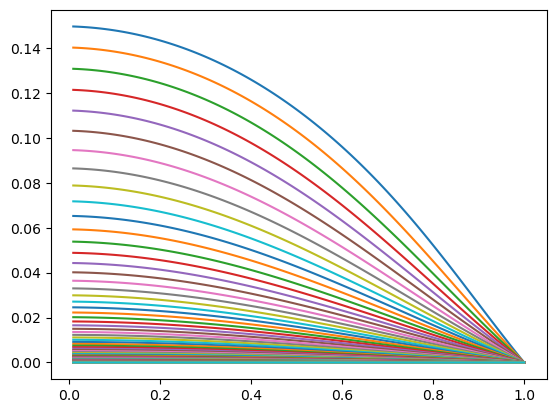

In [9]:
phi = copy(phi0)
errors0 = []
for i in 1:100
    for j in 1:100
        phi = gs_update(xs[2]-xs[1], f_array, phi)
    end
    push!(errors0, (phi[2]-phi_exact[2])/f_array[2])
    plot(xs, abs.(phi-phi_exact)./f_array)
end

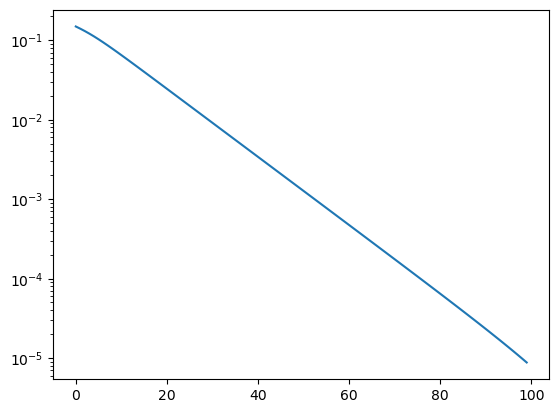

In [10]:
plot(errors0)
yscale("log")

In [11]:
f_array_neumann = -4*pi*pi*cos.(2*pi*xs)
function gs_neumann_update(dx, f_array, phi)
    phi_new = copy(phi)
    
    for i in 2:size(phi_new,1)-1
        phi_new[i] = 0.5*(phi_new[i-1] + phi_new[i+1]) - 0.5*dx*dx*f_array[i]
    end
    
    phi_new[1] = phi_new[2]
    phi_new[end] = phi_new[end-1]
    
    phi_new = phi_new .- sum(phi_new)/size(phi_new,1)
    
    return phi_new
end

gs_neumann_update (generic function with 1 method)

In [12]:
phi = copy(phi0)
for i in 1:100000
    phi = gs_neumann_update(xs[2]-xs[1], f_array_neumann, phi)
end

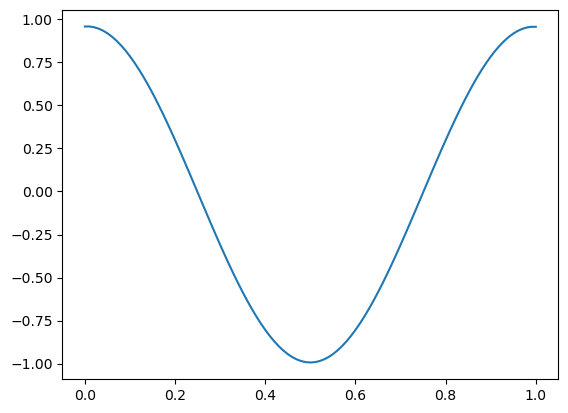

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1313d0048>

In [13]:
plot(xs, phi)

In [15]:
function restrict(phi)
    n = size(phi, 1)
    @assert n % 2 == 1
    
    phi_low = phi[1:2:end]
    
    return phi_low
end

restrict (generic function with 1 method)

In [16]:
function prolong(phi)
    n = size(phi, 1)
    nhigh = 2*n - 1
    phi_high = zeros(nhigh)
    
    for i in 1:n-1
        phi_high[2*i-1] = phi[i]
        phi_high[2*i] = 0.5*(phi[i] + phi[i+1])
    end
    phi_high[2*n-1] = phi[n]
    
    phi_high
end

prolong (generic function with 1 method)

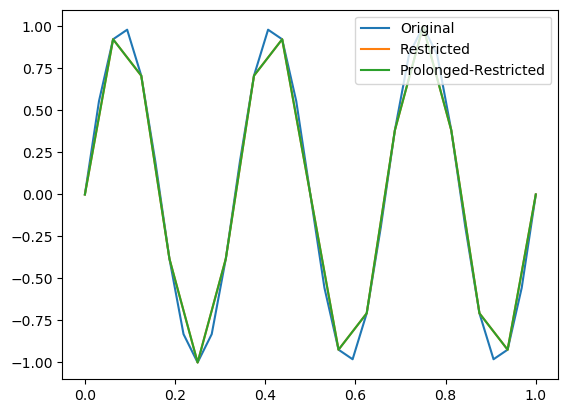

PyObject <matplotlib.legend.Legend object at 0x130fbef98>

In [17]:
xs = collect(range(0, stop=1, length=33))
phi0 = sin.(2*pi*3*xs)
plot(xs, phi0, label="Original")
plot(xs[1:2:end], restrict(phi0), label="Restricted")
plot(xs, prolong(restrict(phi0)), label="Prolonged-Restricted")
legend(loc="best")

In [18]:
function laplace_iterate(dx, phi, f)
    n = size(phi,1)
    
    phi_new = copy(phi)
    for i in 2:n-1
        phi_new[i] = 0.5*(phi_new[i-1] + phi_new[i+1]) - 0.5*dx*dx*f[i]
    end
    phi_new
end

function multigrid_V(dx, phi, f)
    for i in 1:3
        phi = laplace_iterate(dx, phi, f)
    end
    
    if size(phi, 1) == 3
        phi
    else
        r = residual(dx, phi, f)
        
        r_coarse = restrict(r)
        e_coarse = zeros(size(r_coarse, 1))
        
        e_coarse = multigrid_V(2*dx, e_coarse, r_coarse)
        e = prolong(e_coarse)
        
        phi = phi - e
        
        for i in 1:3
            phi = laplace_iterate(dx, phi, f)
        end
        phi
    end
end

multigrid_V (generic function with 1 method)

In [19]:
function residual(dx, phi, f)
    r = copy(phi)
    r[1] = 0.0
    r[end] = 0.0
    for i in 2:size(phi,1)-1
        r[i] = (phi[i-1] + phi[i+1] - 2*phi[i])/(dx*dx) - f[i]
    end
    r
end

residual (generic function with 1 method)

Residual is 0.519533
Residual is 0.0199741
Residual is 0.000781072
Residual is 3.12568e-05
Residual is 1.25876e-06


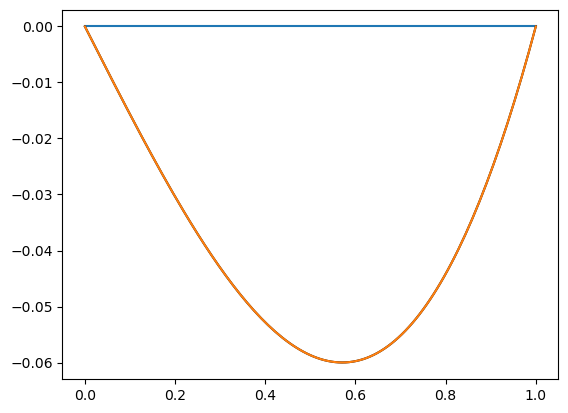

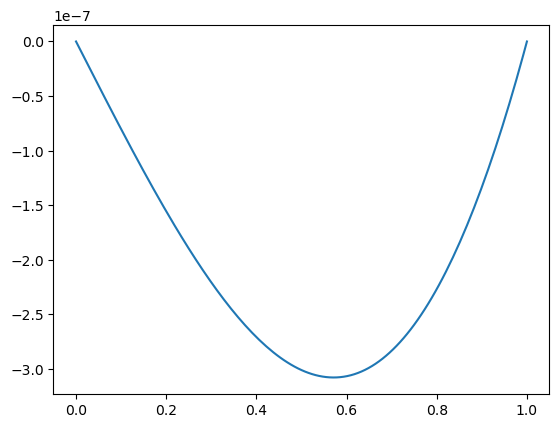

Residual is 5.06826e-08


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x130d4d860>

In [20]:
xs = collect(range(0, stop=1, length=129))
f_array = sin.(xs)
phi_exact = -sin.(xs) + xs.*sin(1)
phi0 = zeros(size(xs,1))
dx = xs[2]-xs[1]
println(@sprintf("Residual is %g", sqrt(dx*sum(residual(dx, phi0, f_array).^2))))
phi = multigrid_V(dx, phi0, f_array)
println(@sprintf("Residual is %g", sqrt(dx*sum(residual(dx, phi, f_array).^2))))
phi = multigrid_V(dx, phi, f_array)
println(@sprintf("Residual is %g", sqrt(dx*sum(residual(dx, phi, f_array).^2))))
phi = multigrid_V(dx, phi, f_array)
println(@sprintf("Residual is %g", sqrt(dx*sum(residual(dx, phi, f_array).^2))))
phi = multigrid_V(dx, phi, f_array)
println(@sprintf("Residual is %g", sqrt(dx*sum(residual(dx, phi, f_array).^2))))
phi = multigrid_V(dx, phi, f_array)
println(@sprintf("Residual is %g", sqrt(dx*sum(residual(dx, phi, f_array).^2))))
plot(xs, phi0)
plot(xs, phi_exact, "-k")
plot(xs, phi)

figure()
plot(xs, phi-phi_exact)

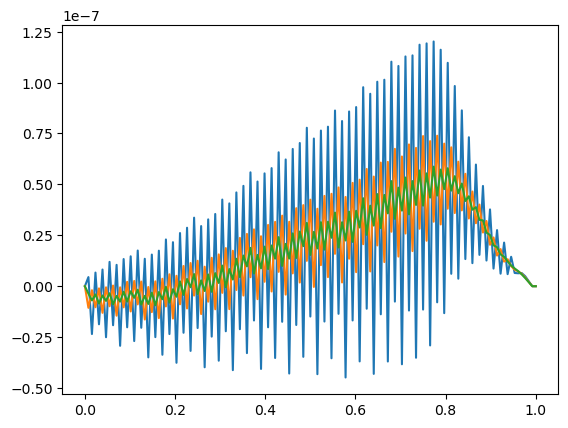

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x131033940>

In [21]:
plot(xs, residual(dx, phi, f_array))
plot(xs, residual(dx, laplace_iterate(dx, phi, f_array), f_array))
plot(xs, residual(dx, laplace_iterate(dx, laplace_iterate(dx, phi, f_array), f_array), f_array))

In [183]:
function nlheat_residual(dx, u)
    r = zeros(size(u,1))
    
    for i in 2:size(u,1)-1
        r[i] = (u[i+1] + u[i-1] - 2.0*u[i])/(dx*dx) - u[i]^4 + 1.0
    end
    
    r
end

function laplace_smooth_nlheat_error(dx, u, r, e)
    e_new = copy(e)
    
    for i in 2:size(e,1)-1
        e_new[i] = (e_new[i-1] + e_new[i+1] - dx*dx*r[i])/(2.0 + 4.0*dx*dx*u[i]^3)
    end
    
    e_new
end

function laplace_smooth_nlheat_error_residual(dx, u, r, e)
    er = zeros(size(e,1))
    
    for i in 2:size(e,1)-1
        er[i] = (e[i+1] + e[i-1] - 2.0*e[i])/(dx*dx) - 4.0*u[i]^3*e[i] - r[i]
    end
    
    er
end

laplace_smooth_nlheat_error_residual (generic function with 1 method)

In [184]:
function multigrid_nlheat_error_V(dx, u, r0, e)
    for i in 1:3
        e = laplace_smooth_nlheat_error(dx, u, r0, e)
    end
    
    if size(u,1) > 3
        r = laplace_smooth_nlheat_error_residual(dx, u, r0, e)
        e_coarse = restrict(e)
        r_coarse = restrict(r)
        u_coarse = restrict(u)

        e_coarse = multigrid_nlheat_error_V(2*dx, u_coarse, r_coarse, e_coarse)
        e = e - prolong(e_coarse)
        
        for i in 1:3 
            e = laplace_smooth_nlheat_error(dx, u, r0, e)
        end
        e
    else
        e
    end
end

multigrid_nlheat_error_V (generic function with 1 method)

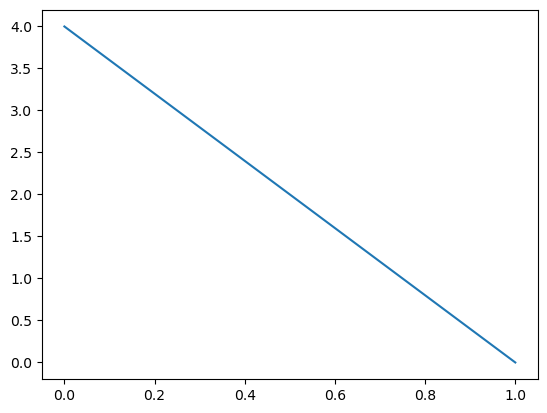

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13cfb3400>

In [185]:
T0 = 4
T1 = 0
xs = collect(range(0, stop=1, length=129))
dx = xs[2]-xs[1]
u0 = collect(range(T0, stop=T1, length=129))
plot(xs, u0)

In [206]:
u = copy(u0);

In [222]:
e = multigrid_nlheat_error_V(dx, u, nlheat_residual(dx, u), zeros(size(u,1)));

In [223]:
u = u-e;

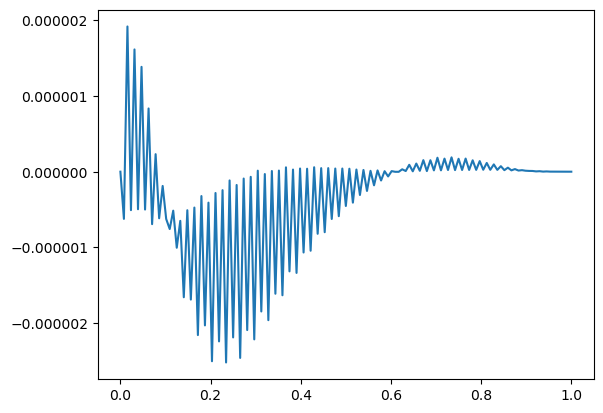

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13e51fcf8>

In [224]:
plot(xs, nlheat_residual(dx, u))

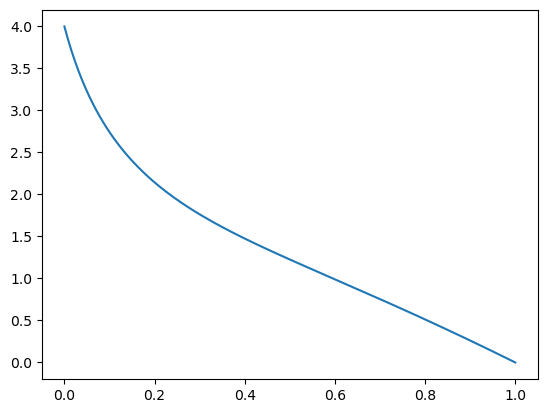

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13e297c88>

In [225]:
plot(xs, u)

In [242]:
function diffusion_residual(dt, dx, u, u_new)
    n = size(u,1)
    r = zeros(n)
    
    for i in 2:n-1
        r[i] = u_new[i]*(1/dt + 1/(dx*dx)) - (u[i]/dt + 1/(2*dx*dx)*(u[i+1]+u[i-1]-2*u[i] + u_new[i+1] + u_new[i-1]))
    end
    
    r[1] = u_new[1]*(1/dt + 1/(dx*dx)) - (u[1]/dt + 1/(2*dx*dx)*(u[2]+u[end-1]-2*u[1] + u_new[2] + u_new[end-1]))
    r[end] = r[1]
    
    r
end

function diffusion_error_smooth(dt, dx, e_new, r)
    n = size(e_new,1)
    e_new = copy(e_new)
    
    for i in 2:n-1
        e_new[i] = (r[i] + 1/(2*dx*dx)*(e_new[i+1] + e_new[i-1]))/(1/dt + 1/(dx*dx))
    end
    
    e_new[1] = (r[1] + 1/(2*dx*dx)*(e_new[2] + e_new[end-1]))/(1/dt + 1/(dx*dx))
    e_new[end] = e_new[1]
    e_new
end

function diffusion_error_residual(dt, dx, e_new, r)
    n = size(e_new,1)
    r_new = zeros(n)
    
    for i in 2:n-1
        r_new[i] = e_new[i]*(1/dt + 1/(dx*dx)) - (r[i] + 1/(2*dx*dx)*(e_new[i+1] + e_new[i-1]))
    end
    r_new[1] = e_new[1]*(1/dt + 1/(dx*dx)) - (r[1] + 1/(2*dx*dx)*(e_new[2] + e_new[end-1]))
    r_new[end] = r_new[1]
    
    r_new
end

diffusion_error_residual (generic function with 1 method)

In [243]:
function diffusion_multigrid_V(dt, dx, e, r)
    for i in 1:3
        e = diffusion_error_smooth(dt, dx, e, r)
    end
    
    n = size(e,1)
    
    if n > 3
        e_restrict = restrict(e)
        r_restrict = restrict(diffusion_error_residual(dt, dx, e, r))
        e_restrict = diffusion_multigrid_V(dt, 2*dx, e_restrict, r_restrict)
        
        e = e - prolong(e_restrict)
        for i in 1:3
            e = diffusion_error_smooth(dt, dx, e, r)
        end
    
        e
    else
        e
    end
end

diffusion_multigrid_V (generic function with 1 method)

In [244]:
function diffusion_timestep(dt, dx, u)
    u_new = copy(u)
    
    for i in 1:5
        r = diffusion_residual(dt, dx, u, u_new)
        e = zeros(size(u,1))
        e = diffusion_multigrid_V(dt, dx, e, r)

        u_new = u_new - e
    end
    
    u_new
end

diffusion_timestep (generic function with 1 method)

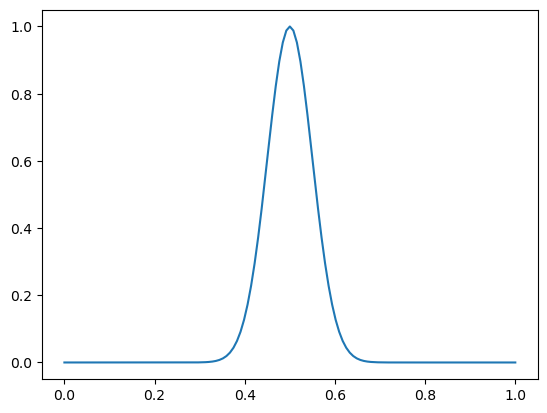

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13f9615f8>

In [257]:
xs = collect(range(0, stop=1, length=129))
u0 = exp.(-(xs.-0.5).^2/0.05^2/2)
dx = xs[2]-xs[1]
dt = dx/10
plot(xs, u0)

In [262]:
u = copy(u0)
for i in 1:32
    u = diffusion_timestep(dt, dx, u)
end

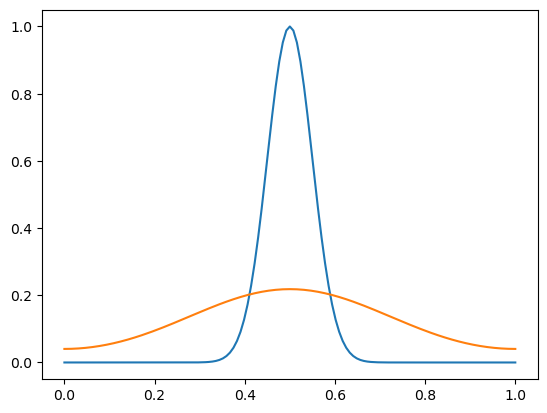

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13fc707f0>

In [263]:
plot(xs, u0)
plot(xs, u)